In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn.objects as so

mpl.rcParams['figure.dpi']= 300

In [2]:
# Read in processed data
data_dir = Path("../data")
file_path = data_dir / "raw-roast-reviews-openrefine.csv"
df = pd.read_csv(file_path)
df.head()

,roaster_location,country,coordinate location,located in the administrative territorial entity,roaster_location_identifier,coffee_origin,origin_country_cluster,roast_level,agtron,est_price,...,aftertaste,rating,roaster,name,blind_assessment,notes,bottom_line,url,with_milk,acidity
0,Hong Kong,People's Republic of China,"22.278333333333,114.15861111111",People's Republic of China,Q8646,multiple,multiple,Medium-Light,60/78,CNY 160/250 grams,...,8.0,92,Nodi Coffee,Windsor Blend,"Gently fruit-toned, delicately floral. Apricot...","A blend of two coffees, one Ethiopia and one R...",Bright stone fruit and crisp cocoa nib charact...,https://www.coffeereview.com/review/windsor-bl...,NaN,NaN
1,Madison,United States of America,"43.07472222222222,-89.38416666666667",Dane County,Q43788,"Nyeri growing region, south-central Kenya","Nyeri growing region, Kenya",Medium-Light,56/74,$22.00/12 ounces,...,8.0,94,JBC Coffee Roasters,Nyeri Hill Kenya,"Richly sweet-tart. Blackberry compote, cocoa n...","Produced at Nyeri Hill Estate, from trees of t...","A complex, multi-layered, classic Kenya cup, b...",https://www.coffeereview.com/review/nyeri-hill...,NaN,NaN
2,Plymouth,United States of America,"41.95861111111111,-70.66777777777777",Plymouth County,Q326295,"Monte Verde, Santa Ana Department, central El ...","Apaneca-Ilamatepec growing region, El Salvador",Medium-Light,58/74,$16.00/12 ounces,...,8.0,92,Speedwell Coffee,El Salvador Los Cipreses,"Richly sweet, floral-toned. Nutella, magnolia,...",Produced by Rene Contreras on the family farm ...,"A harmonious, floral and chocolaty washed El S...",https://www.coffeereview.com/review/el-salvado...,NaN,NaN
3,Madison,United States of America,"43.07472222222222,-89.38416666666667",Dane County,Q43788,"Tarrazu, Costa Rica","Tarrazú growing region, Costa Rica",Medium-Light,59/77,$18.00/8 ounces,...,8.0,94,JBC Coffee Roasters,Cordillera de Fuego Costa Rica,"Richly sweet, deeply spice-toned. Cinnamon, cl...","Produced by Luis Eduardo Campos, from trees of...","A thoroughly spice-toned anaerobic Costa Rica,...",https://www.coffeereview.com/review/cordillera...,NaN,NaN
4,Peoria,United States of America,"40.6925,-89.59",Peoria County,Q233129,"Los Robles de Naranjo, West Valley, Costa Rica","West Valley growing region, Costa Rica",Medium-Light,57/76,$22.00/12 ounces,...,8.0,93,Intuition Coffee,Costa Rica Finca Tono Natural,"Gently fruity, richly nut-toned. Hazelnut butt...","Produced by Felipe and Erasmo Aguilera, entire...","A delicate, nuanced natural-processed Costa Ri...",https://www.coffeereview.com/review/costa-rica...,NaN,NaN


In [4]:
def tweak_df(df):
    return (df
            .replace('na', np.nan)
            .dropna(subset=['origin_country_cluster', 'roaster_location', 'roast_level', 'body', 'aroma'])
            .assign(origin_country=lambda df_: (df_['origin_country_cluster']
                                                .str.split(',')
                                                .str[-1]
                                                .str.strip()
                                                ),
                    origin_region=lambda df_: (df_['origin_country_cluster']
                                               .str.split(',')
                                               .str[:-1]
                                               .str.join(',')
                                               .str.strip()
                                               ),
                    review_date = lambda df_: pd.to_datetime(df_['review_date'], format="%B %Y"),
                    acidity = lambda df_: df_['acidity'].fillna(df_['acidity/structure']),
                    agtron_external = lambda df_: (df_['agtron']
                                                   .str.split('/')
                                                   .str[0].str.strip()
                                                   .replace(['', 'NA', 'g', '0'], np.nan)
                                                   ),
                    agtron_ground = lambda df_: (df_['agtron']
                                                 .str.split('/')
                                                 .str[1].str.strip()
                                                 .replace(['', 'NA', 'wb', '0'], np.nan)),
            )
            .drop(columns=['acidity/structure', 'with_milk', 'bottom_line', 'agtron'])
            .dropna(subset=['acidity']) # drop rows where acidity is still NaN, these are espresso reviews
            .rename(columns={'country': 'roaster_country', 'roaster_location': 'roaster_city', 
                             'located in the administrative territorial entity': 'roaster_region',
                             'coordinate location': 'roaster_coordinates'})
            .assign(origin_region=lambda df_: df_['origin_region'].replace('', np.nan))
            .astype({'agtron_external': 'Int64', 'agtron_ground': 'Int64', 'acidity': 'float',
                     'aftertaste': 'Int64', 'aroma': 'float', 'body': 'float',
                     'rating': 'Int64', 'flavor': 'float',})
    )

coffee = tweak_df(df)
coffee.head()

,roaster_city,roaster_country,roaster_coordinates,roaster_region,roaster_location_identifier,coffee_origin,origin_country_cluster,roast_level,est_price,review_date,...,roaster,name,blind_assessment,notes,url,acidity,origin_country,origin_region,agtron_external,agtron_ground
0,Hong Kong,People's Republic of China,"22.278333333333,114.15861111111",People's Republic of China,Q8646,multiple,multiple,Medium-Light,CNY 160/250 grams,2023-11-01,...,Nodi Coffee,Windsor Blend,"Gently fruit-toned, delicately floral. Apricot...","A blend of two coffees, one Ethiopia and one R...",https://www.coffeereview.com/review/windsor-bl...,8.0,multiple,NaN,60,78
1,Madison,United States of America,"43.07472222222222,-89.38416666666667",Dane County,Q43788,"Nyeri growing region, south-central Kenya","Nyeri growing region, Kenya",Medium-Light,$22.00/12 ounces,2023-12-01,...,JBC Coffee Roasters,Nyeri Hill Kenya,"Richly sweet-tart. Blackberry compote, cocoa n...","Produced at Nyeri Hill Estate, from trees of t...",https://www.coffeereview.com/review/nyeri-hill...,9.0,Kenya,Nyeri growing region,56,74
2,Plymouth,United States of America,"41.95861111111111,-70.66777777777777",Plymouth County,Q326295,"Monte Verde, Santa Ana Department, central El ...","Apaneca-Ilamatepec growing region, El Salvador",Medium-Light,$16.00/12 ounces,2023-12-01,...,Speedwell Coffee,El Salvador Los Cipreses,"Richly sweet, floral-toned. Nutella, magnolia,...",Produced by Rene Contreras on the family farm ...,https://www.coffeereview.com/review/el-salvado...,9.0,El Salvador,Apaneca-Ilamatepec growing region,58,74
3,Madison,United States of America,"43.07472222222222,-89.38416666666667",Dane County,Q43788,"Tarrazu, Costa Rica","Tarrazú growing region, Costa Rica",Medium-Light,$18.00/8 ounces,2023-12-01,...,JBC Coffee Roasters,Cordillera de Fuego Costa Rica,"Richly sweet, deeply spice-toned. Cinnamon, cl...","Produced by Luis Eduardo Campos, from trees of...",https://www.coffeereview.com/review/cordillera...,9.0,Costa Rica,Tarrazú growing region,59,77
4,Peoria,United States of America,"40.6925,-89.59",Peoria County,Q233129,"Los Robles de Naranjo, West Valley, Costa Rica","West Valley growing region, Costa Rica",Medium-Light,$22.00/12 ounces,2023-12-01,...,Intuition Coffee,Costa Rica Finca Tono Natural,"Gently fruity, richly nut-toned. Hazelnut butt...","Produced by Felipe and Erasmo Aguilera, entire...",https://www.coffeereview.com/review/costa-rica...,8.0,Costa Rica,West Valley growing region,57,76


In [5]:
def load_json(file_path):
    with open(file_path) as f:
        return json.load(f)

conversions = load_json(data_dir / "conversions.json")
grams_conversions = conversions['grams_conversions']
currency_map = conversions['currency_map']

In [6]:
quantity = (
    df['est_price']
    .str.split('[/;]', n=1, expand=True)
    .dropna()
    .rename(columns={0: 'price', 1: 'amount'})
    .loc[:, 'amount']
    .str.replace('oz.*|ouncues|onces|ounce$|-ounce', 'ounces', regex=True)  # Consolidated handling for "ounces"
    .str.replace('g |g. | g. |g$', 'grams', regex=True)  # Consolidated handling for "grams"
    .str.replace(r'-gram', ' grams', regex=True)
    .str.replace(r'\([^)]*\)', '', regex=True)  # Handles any content within parentheses
    .str.replace(';|\(|\$.*|tin', '', regex=True)  # Remove unwanted characters and substrings
    .str.replace('  ', ' ', regex=True)  # Replace double spaces with single
    .str.replace('8 18 grams pouches', '152 grams', regex=False)  # Specific case replacements
    .str.replace('350 grams 12.3 ounces', '350 grams', regex=False)
    .str.strip()  # Trim whitespace
    .mask(lambda x: x.str.contains('capsule|packet|pods|vue|k-cups|sticks|tubes|cups|boxed|discs|can', case=False), np.nan)
    # Set the value to NaN if certain words are present, indicating non-standard quantities
)

print(quantity)

0       250 grams
1       12 ounces
2       12 ounces
3        8 ounces
4       12 ounces
          ...    
6456    12 ounces
6468    16 ounces
6470    12 ounces
6471    16 ounces
6725    16 ounces
Name: amount, Length: 5509, dtype: object


In [39]:
quantity_unit = (
    quantity
    .str.split(' ', expand=True)
    .rename(columns={0: 'quantity', 1: 'unit'})
    .replace({'pound': '1 pounds'})  # Handle the special case where 'pound' should be considered as '1 pound'
    .assign(
        quantity=lambda df_: df_['quantity'].str.extract('(\d+)')[0].astype(float),  # Extract numeric part and convert to float
        unit=lambda df_: df_['unit'].str.extract('([a-zA-Z]+)')[0]  # Extract unit part
    )
    .replace({'unit': {'pounds': 'pound',}})  # Normalize singular 'pounds' to 'pound' if needed
    .assign(quantity_grams=lambda df_: df_['quantity'] * df_['unit'].map(grams_conversions))
    .fillna(value=np.nan)
    .drop(columns=[2, 3])
    .dropna()
)

quantity_unit


,quantity,unit,quantity_grams
0,250.0,grams,250.000
1,12.0,ounces,340.194
2,12.0,ounces,340.194
3,8.0,ounces,226.796
4,12.0,ounces,340.194
...,...,...,...
6456,12.0,ounces,340.194
6468,16.0,ounces,453.592
6470,12.0,ounces,340.194
6471,16.0,ounces,453.592


In [62]:

price = (
    df['est_price']
      .str.split('[/;]', n=1, expand=True)  # Split the string by '/' or ';' and expand to new DataFrame
      .iloc[:, 0]                           # Select the first column (price part before '/' or ';')
      .str.replace(',', '', regex=False)    # Remove commas from the price for proper conversion
      .str.extract(r'(\d+\.\d+|\d+)')       # Use regex to extract the complete price
      .iloc[:, 0]                           # Select the first column of the extraction result                   # Convert the extracted string to float
      .rename('nominal_price')
      .dropna()
)

price

0         160
1       22.00
2       16.00
3       18.00
4       22.00
        ...  
6456    14.99
6468    45.99
6470    19.95
6471       30
6725    11.95
Name: nominal_price, Length: 5513, dtype: object

In [64]:
currency = (
        df['est_price']
            .str.split('[/;]', n=1, expand=True)
            .loc[:, 0]
            .str.replace(',', '', regex=False)
            .str.replace(r'(\d+\.\d+|\d+)', '', regex=True)
            .str.strip()
            .str.replace(' ', '')
            .map(currency_map, na_action='ignore')
            .rename('currency')
            )


currency.value_counts()
#df = df.join(quantity_unit, how='left').join(price, how='left').join(currency, how='left')

currency
USD    4247
TWD     957
CAD     129
HKD      46
CNY      27
THB      21
KRW      20
GBP      18
JPY      14
AUD      10
AED       5
EUR       4
IDR       3
MXN       1
GTQ       1
Name: count, dtype: int64

In [5]:
with open('data/exchange_rates.json', 'r') as f:
    exchange_rates = json.load(f)
    
df = (df
      .dropna(subset=['review_date', 'currency'])
      .astype({'review_date': 'str'})
      .assign(exchange_rate = lambda df_: df_.apply(lambda x: exchange_rates[x['review_date']][x['currency']], axis=1))
      .assign(price_usd = lambda df_: df_['nominal_price'] / df_['exchange_rate'])
      .assign(review_date = lambda df_: pd.to_datetime(df_['review_date']))
      .round({'price_usd': 2})
)

FileNotFoundError: [Errno 2] No such file or directory: 'data/exchange_rates.json'

In [6]:
# Read in CPI data
def cpi_date(filepath: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(filepath).drop(columns=['HALF1', 'HALF2'])
    except Exception as e:
        print(e)
    return (df
          .melt(id_vars='Year', var_name='Month', value_name='cpi')
          .assign(date=lambda df_: pd.to_datetime(df_['Year'].astype(str) + '-' + df_['Month'], format='mixed'))
          .dropna(subset=['cpi'])
          .sort_values('date')
          .drop(columns=['Year', 'Month'])
    )

cpi = cpi_date('data/cpi.csv')
cpi_jan_2024 = cpi.loc[cpi['date'] == '2024-01-01', 'cpi'].values[0]

[Errno 2] No such file or directory: 'data/cpi.csv'


UnboundLocalError: cannot access local variable 'df' where it is not associated with a value

In [7]:
(
    df
    .join(cpi.set_index('date'), on='review_date')
    # Past dollars in terms of recent dollars = Dollar amount × Ending-period CPI / Beginning-period CPI.
    .assign(price_USD_2024 = lambda df_: np.round(df_['price_usd'] * cpi_jan_2024 / df_['cpi'], 2))
    .assign(price_USD_2024_per_100g = lambda df_: np.round(df_['price_USD_2024'] / df_['quantity_grams'] * 100, 2))

)

NameError: name 'df' is not defined

In [8]:
def plot_ratings_distribution(df):
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(data=df.astype({'rating':'float'}), x='rating',kde=True, discrete=True)
    ax.set_title('Distribution of ratings')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')
    ax.axvline(df['rating'].mean(), color='black', linestyle='--', label='mean')
    ax.axvline(df['rating'].median(), color='black', linestyle='-', label='median')
    ax.legend()
    plt.show()
    
plot_ratings_distribution(df)

NameError: name 'df' is not defined

In [9]:
# plot number of reviews by country in seaborn
def plot_reviews_by_country(df):
    plt.figure(figsize=(10, 6))
    df = df.replace('Democratic Republic of the Congo', 'DRC')
    ax = sns.countplot(y='origin_country', data=df, order = df['origin_country'].value_counts().index)
    ax.bar_label(ax.containers[0], fontsize=6,)
    plt.yticks(fontsize=8)
    plt.title('Number of reviews by origin country')
    plt.xlabel('Number of reviews')
    plt.ylabel('Country')
    plt.tight_layout()
    plt.show()

plot_reviews_by_country(df)

NameError: name 'df' is not defined

NameError: name 'df' is not defined

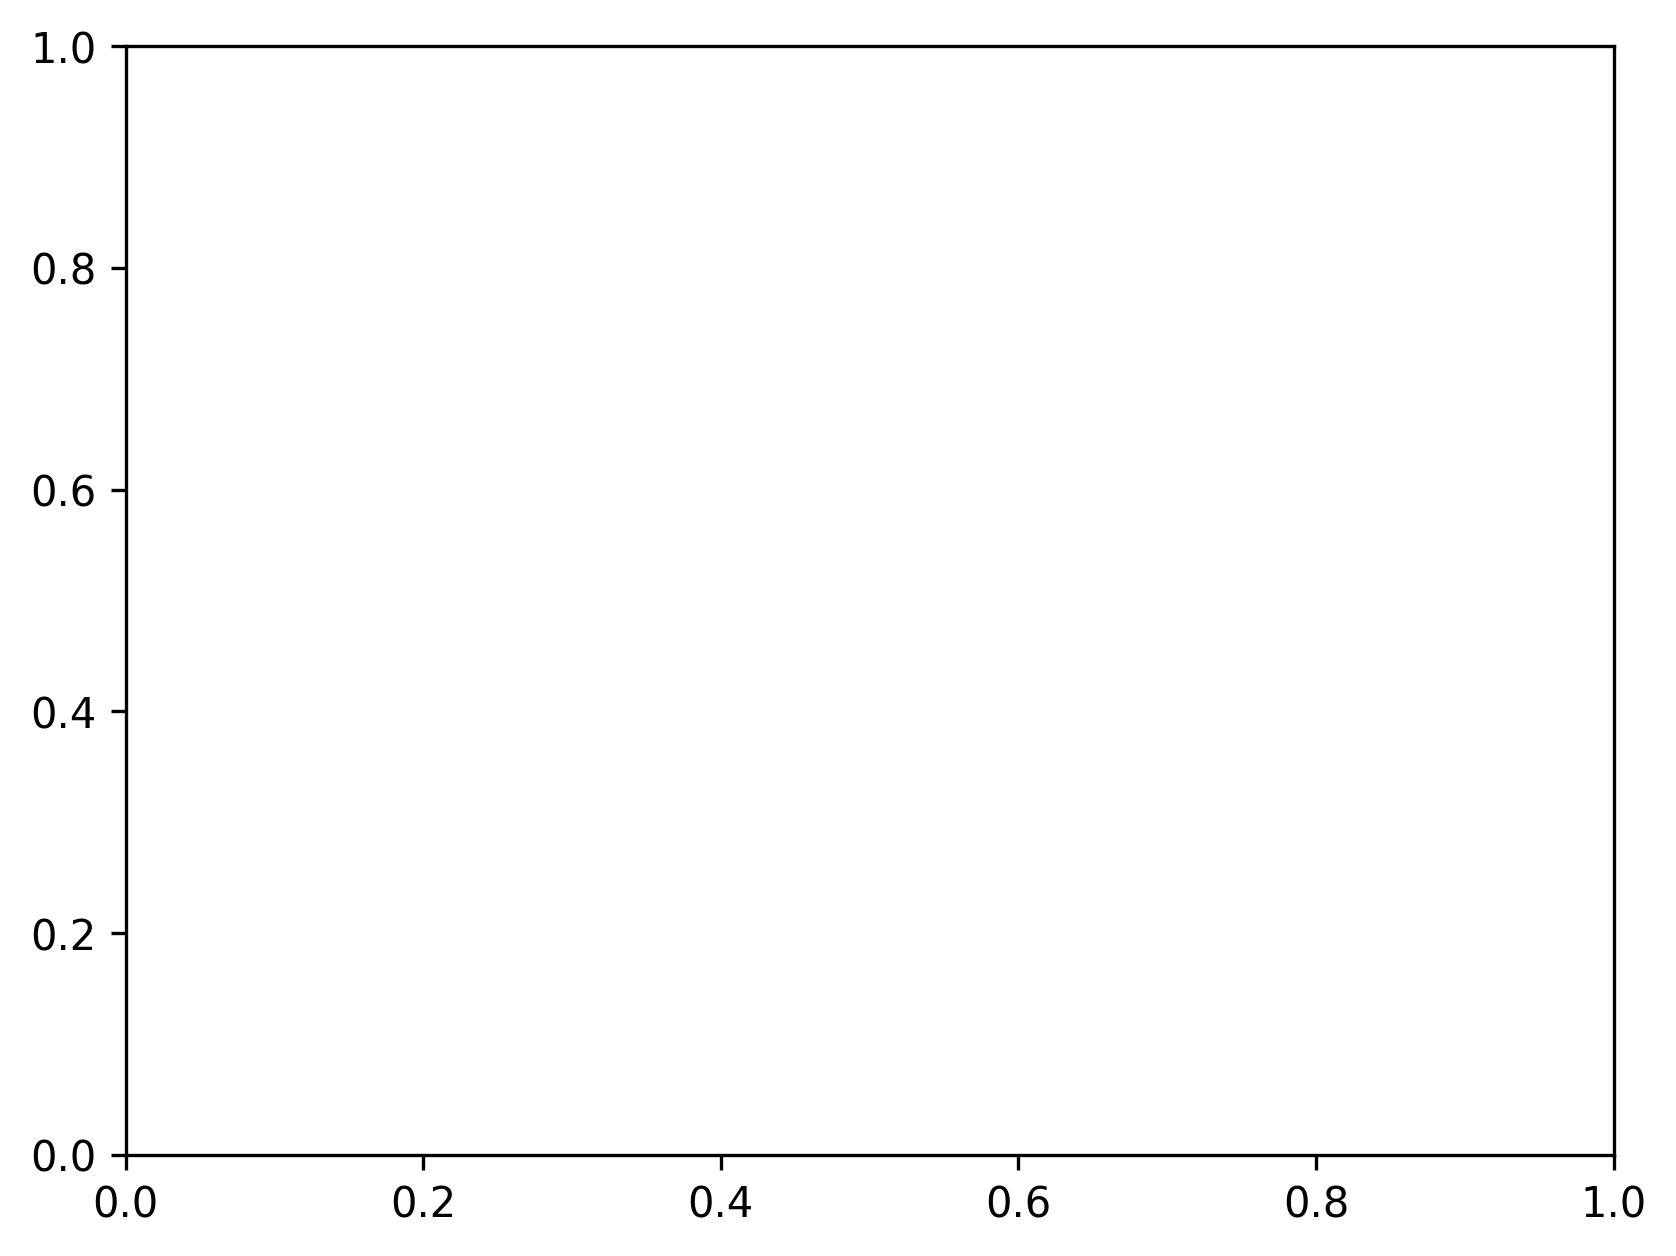

In [10]:
# PLot number of reviews per year. Plot Cumulative number of reviews on top of that.
# plot cumulative reviews over years in seaborn

fig, ax = plt.subplots()
year = df['review_date'].dt.year.value_counts().sort_index()
cumsum = df['review_date'].dt.year.value_counts().sort_index().cumsum()
sns.lineplot(x=year.index, y=year, ax=ax, )
ax.set_title('Number of Reviews per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Reviews')
plt.show()


# plot number of reviews per roaster_country ordered by number of reviews

fig, ax = plt.subplots()
country = df['roaster_country'].value_counts().sort_values(ascending=False)
sns.barplot(x=country.index, y=country, ax=ax, order=country.index)
ax.set_title('Number of Reviews per Roaster Country')
ax.set_xlabel('Roaster Country')
ax.set_ylabel('Number of Reviews')
plt.xticks(rotation=90)

for i,v in enumerate(country):
    ax.text(i, v+20, str(v), ha='center', fontsize=8)
plt.show()



## EDA

### Descriptive Statistics:
Calculate **basic statistics** like **mean, median, and standard deviation** for the 'Rating,' 'Aroma,' 'Acidity,' 'Body,' 'Flavor,' 'Aftertaste,' and 'Price' columns to get an overall understanding of the dataset. Find out how often different roasters and locations appear in the dataset. 

### Distributions:
Visualize the **distributions** of 'Rating,' 'Aroma,' 'Acidity,' 'Body,' 'Flavor,' and 'Aftertaste' using to understand the spread of values.

### Correlations:
Investigate the **correlations** between different attributes such as 'Rating,' 'Aroma,' 'Acidity,' 'Body,' 'Flavor,' and 'Aftertaste.' Identify which attributes tend to go together or have an impact on the overall rating.

### Top Roasters and Coffees:
Identify the top-rated roasters and coffee names based on the 'Rating' column. 

### Quantity Analysis:
Investigate the 'Quantity' and 'Unit' columns to understand the different packaging sizes and units in which coffee is sold. Analyze how these factors relate to pricing and consumer preferences.

### Roaster Performance:
Evaluate roasters' performance based on their ratings and the origin of the coffee beans. Are there specific regions or origins associated with higher ratings for particular roasters?

## Deeper Analysis:

### Geospatial Analysis:
Analyze the 'Roaster_Location' and 'Origin' columns to understand where the roasters are located and where the coffee beans are sourced from. You can use geospatial tools to create maps or investigate the relationship between origin and rating.

### Currency Analysis:
Analyze the 'Currency' column to understand the currencies used for pricing. You can convert prices to a common currency (e.g., USD) for comparison.

### Price Analysis:
Analyze the relationship between 'Price' and 'Rating.' Do higher-priced coffees tend to have higher ratings? You can also look for outliers in pricing.Investigate the relationship between pricing ('Price' and 'Currency') and sensory attributes ('Aroma,' 'Acidity,' 'Body,' 'Flavor,' 'Aftertaste'). Are there pricing strategies associated with higher ratings?

### Text Analysis:
Perform natural language processing (NLP) on the 'Review_Description,' 'Blind_Assessment,' and 'Notes' columns to extract insights about the sensory descriptions, flavor profiles, and unique characteristics of the coffees.

In [22]:
quantity = (
    df['est_price']
    .str.split('[/;]', n=1, expand=True)
    .dropna()
    .rename(columns={0: 'price', 1: 'amount'})
    .loc[:, 'amount']
    .str.replace('oz.*|ouncues|onces|ounce$|-ounce', 'ounces', regex=True)  # Consolidated handling for "ounces"
    .str.replace('g |g. | g. |g$', 'grams', regex=True)  # Consolidated handling for "grams"
    .str.replace(r'-gram', ' grams', regex=True)
    .str.replace(r'\([^)]*\)', '', regex=True)  # Handles any content within parentheses
    .str.replace(';|\(|\$.*|tin', '', regex=True)  # Remove unwanted characters and substrings
    .str.replace('  ', ' ', regex=True)  # Replace double spaces with single
    .str.replace('8 18 grams pouches', '152 grams', regex=False)  # Specific case replacements
    .str.replace('350 grams 12.3 ounces', '350 grams', regex=False)
    .str.strip()  # Trim whitespace
    .mask(lambda x: x.str.contains('capsule|packet|pods|vue|k-cups|sticks|tubes|cups|boxed|discs|can', case=False), np.nan)
    # Set the value to NaN if certain words are present, indicating non-standard quantities
)

print(quantity)

0       250 grams
1       12 ounces
2       12 ounces
3        8 ounces
4       12 ounces
          ...    
6456    12 ounces
6468    16 ounces
6470    12 ounces
6471    16 ounces
6725    16 ounces
Name: amount, Length: 5509, dtype: object
